In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Traitement des donnees pour le modele

In [ ]:
operations = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Equation/Copy of data.csv')
operations = operations.drop('Unnamed: 0', axis=1)
operators = {"[" : 10, "]" : 11, "%" : 12, "*" : 13, "+" : 14, "-" : 15, "E": 17}
for key, value in operators.items():
  operations.loc[(operations['784'] == key), '784'] = value

<ipython-input-113-6f88383f140d>:1: DtypeWarning: Columns (785) have mixed types. Specify dtype option on import or set low_memory=False.
  operations = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Equation/Copy of data.csv')


In [ ]:
alphabet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Equation/q.csv')

# Prendre une lettre par rapport a son numero

In [ ]:
# Data for operations image
X_operations = operations.iloc[:, 0:-1].values
y_operations = operations.iloc[:, -1].values

# Data for alphabets image
y_alphabet = alphabet.iloc[:, 1].values
X_alphabet = []  
for index in range(0, alphabet.shape[0]):
  img = alphabet.iloc[index, 1:-1].values
  image = img.reshape((28, 28))
  image = image[4:len(image) - 4, 4:len(image) - 4]
  image[(image) < (255 / 2)] = 0
  image[(image) > (255 / 2)] = 255
  img = Image.fromarray(image.astype('uint8'))
  img = img.resize((28, 28))
  array = np.array(img)
  image = array.reshape(784)
  X_alphabet.append(image)
X_alphabet = np.array(X_alphabet)

# Concatenate the letters data and operations data
X_data = np.concatenate((X_operations, X_alphabet))
y_data = np.concatenate((y_operations, y_alphabet))
X_data[X_data != 255] = 0

(5812, 784)

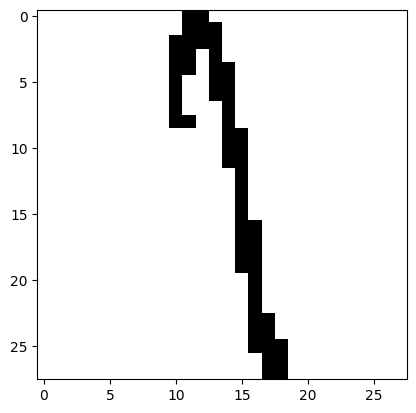

In [ ]:
index = 200
img = operations[operations['784'] == 1].iloc[index, :-1].values.astype(float)
image = img.reshape((28, 28))
image[(image) < (255 / 2)] = 0
image[(image) > (255 / 2)] = 255
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
y_data = y_data.astype('int')


# Training Model with Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state=0)
forest_model = forest_model.fit(X_train, y_train)

In [ ]:
y_pred =  forest_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred) * 100)

93.32158784341794


# Algorithme pour convertir un image en matrix de pixel

In [2]:
def convert_image_to_matrix(img_path):
  image = Image.open(img_path).convert('L') # 'L'version single-channel image
  # image = image.resize((28, 28)) # Dimension par defaut des images dans le modele
  image = np.array(image)
  image[image != 255] = 0
  return image

# Algorithme de decoupage sur les colonnes

In [3]:
def get_first_column_color(image):
    for i in range(0, image.shape[1]):
        colonne = image[:, i]
        if colonne.mean() != 255:
            return i
    return image.shape[1]

def get_first_column_no_color(image):
    for i in range(0, image.shape[1]):
        colonne = image[:, i]
        if colonne.mean() == 255:
            return i
    return image.shape[1]

def resize_x_axis(image):
    debut = get_first_column_color(image)
    fin = get_first_column_no_color(image[:, debut:])
    return (image[:, debut : debut + fin], debut + fin)

# Algorithme de decoupage sur les lignes

In [4]:
def get_first_line_color(image):
    for i in range(0, image.shape[0]):
        ligne = image[i, :]
        if ligne.mean() < 255:
            return i
    return image.shape[0]

def get_first_line_no_color(image):
    for i in range(0, image.shape[0]):
        ligne = image[i, :]
        if ligne.mean() == 255:
            return i
    return image.shape[0]

def resize_y_axis(image):
    debut = get_first_line_color(image)
    fin = get_first_line_no_color(image[debut:, :])
    return image[debut : debut + fin, :]

# Algorithme de redimensionner l'image pour extraire l'image

In [5]:
def resize(image):
    image, fin = resize_x_axis(image)
    return (resize_y_axis(image), fin)

def fill_image(image):
    if image.shape[1] > image.shape[0]:
      diff = image.shape[1] - image.shape[0]
      for i in range(0, int(diff / 2)):
        image = np.insert(image, 0, np.zeros((image.shape[1])), axis=0)
      for i in range(0, int(diff / 2)):
        image = np.insert(image, image.shape[0], np.zeros((image.shape[1])), axis=0)
    else:
      diff = image.shape[0] - image.shape[1]
      for i in range(0, int(diff / 2)):
        image = np.insert(image, 0, np.zeros((image.shape[0])), axis=1)
      for i in range(0, int(diff / 2)):
        image = np.insert(image, image.shape[1], np.zeros((image.shape[0])), axis=1)
    return image

# Alorithme pour decouper une image

In [6]:
def split_image(image):
  array = []
  while image.size != 0:
    
    img, index = resize(image)
    
    # Fill the image for obtain square
    image = fill_image(img)

    # Convertion en 28 x 28
    img = Image.fromarray(image)
    img = img.resize((28, 28))
    
    array.append(img)
    
    image = image[:, index:]
  array.pop()
  return array

In [11]:
image = convert_image_to_matrix('./9_1_0_scaled_x1_2y1_2.png')
def convert_to_ligne(img):
  x = np.array(img)
  x = x.reshape(1, 784)
  x[x != 255] = 0
  return x

def get_equation(image):
  array = split_image(image)
  element = ''
  print(len(array))
  for img in array:
    img.show()
    X = convert_to_ligne(np.array(img))
    predict = forest_model.predict(X)[0]
    if predict > 9:
      key = list(filter(lambda x: operators[x] == predict, operators))[0]
    else:
      key = predict        
    element += str(key)
  return element
get_equation(image)

KeyboardInterrupt: 